# BirdCLEF 2025 - Complete Pipeline (STFT-Optimized)
## Feature Extraction + EfficientNet-B1 Training

This notebook contains the **complete optimized pipeline**:
1.  Setup & data exploration
2.  Install libraries
3.  Create filename mappings
4.  Read CSV metadata
5.  Extract mel-spectrogram features (STFT-optimized, float16)
6.  Train EfficientNet-B1 with mixup + label smoothing
7.  Evaluate & save results

**Optimizations:**
-  STFT-based feature extraction (faster than librosa)
-  float16 storage (50% memory savings)
-  ~35 minutes for feature extraction (vs 45 with librosa)
-  Same 94-95% accuracy expected

**Expected Timeline:**
- Feature extraction: ~35 minutes (28,564 files in 190 chunks)
- Training: ~90 minutes (30 epochs × 3 min/epoch)
- **Total: ~2 hours 5 minutes**

## PART 1: DATA PREPARATION

### Cell 1: Setup and Explore Dataset

In [1]:
import os
import glob
import math
import random
import gc
import numpy as np
from pathlib import Path
from tqdm import tqdm

print("Core libraries imported")

# Check Kaggle input directory
input_dir = '/kaggle/input'
print("\nContents of /kaggle/input:")
for item in os.listdir(input_dir):
    path = os.path.join(input_dir, item)
    if os.path.isdir(path):
        file_count = sum([len(files) for _, _, files in os.walk(path)])
        print(f"   {item}/ ({file_count} files)")
    else:
        print(f"   {item}")

# Check for BirdCLEF dataset
birdclef_path = '/kaggle/input/birdclef-2025'
if os.path.exists(birdclef_path):
    print(f"\n Found BirdCLEF dataset at {birdclef_path}")
    audio_path = os.path.join(birdclef_path, 'train_audio')
    if os.path.exists(audio_path):
        audio_files = []
        for root, dirs, files in os.walk(audio_path):
            audio_files.extend([f for f in files if f.endswith('.ogg')])
        print(f" Found {len(audio_files):,} audio files in {audio_path}")
    else:
        print(f"train_audio directory not found")
else:
    print(f"BirdCLEF dataset not found at {birdclef_path}")

✅ Core libraries imported

Contents of /kaggle/input:
  📁 birdclef-2025/ (38295 files)

✅ Found BirdCLEF dataset at /kaggle/input/birdclef-2025
✅ Found 28,564 audio files in /kaggle/input/birdclef-2025/train_audio


### Cell 2: Install Required Libraries

In [2]:
# Install audio processing and ML libraries
!pip install -q librosa soundfile scipy

# Install PyTorch and timm
!pip install -q timm torch torchvision

print(" All libraries installed successfully")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 10.4 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

### Cell 3: Build Filename to Path Mapping

In [3]:
audio_path = '/kaggle/input/birdclef-2025/train_audio'

# Build mapping of filename -> full path
basename_to_path = {}
filename_to_path = {}

print("Building filename mappings...")
for root, dirs, files in os.walk(audio_path):
    for file in files:
        if file.endswith('.ogg'):
            full_path = os.path.join(root, file)
            basename_to_path[file] = full_path
            
            # Also store with subdirectory
            subdir = os.path.basename(root)
            full_filename = f"{subdir}/{file}"
            filename_to_path[full_filename] = full_path

print(f" Mapped {len(basename_to_path):,} files")
print(f"Sample mappings (first 5):")
for i, (fname, fpath) in enumerate(list(basename_to_path.items())[:5]):
    print(f"  {fname} -> .../{os.path.basename(fpath)}")

Building filename mappings...
✅ Mapped 28,552 files
Sample mappings (first 5):
  XC132190.ogg -> .../XC132190.ogg
  iNat178385.ogg -> .../iNat178385.ogg
  XC257720.ogg -> .../XC257720.ogg
  XC9313.ogg -> .../XC9313.ogg
  XC556246.ogg -> .../XC556246.ogg


### Cell 4: Read CSV Metadata

In [4]:
import pandas as pd

csv_path = '/kaggle/input/birdclef-2025/train.csv'
df = pd.read_csv(csv_path)

print(f"CSV shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nUnique primary_labels: {df['primary_label'].nunique()}")
print(f"\nLabel distribution (top 10):")
print(df['primary_label'].value_counts().head(10))

CSV shape: (28564, 13)

Columns: ['primary_label', 'secondary_labels', 'type', 'filename', 'collection', 'rating', 'url', 'latitude', 'longitude', 'scientific_name', 'common_name', 'author', 'license']

First 5 rows:
  primary_label secondary_labels  type              filename collection  \
0       1139490             ['']  ['']  1139490/CSA36385.ogg        CSA   
1       1139490             ['']  ['']  1139490/CSA36389.ogg        CSA   
2       1192948             ['']  ['']  1192948/CSA36358.ogg        CSA   
3       1192948             ['']  ['']  1192948/CSA36366.ogg        CSA   
4       1192948             ['']  ['']  1192948/CSA36373.ogg        CSA   

   rating                                                url  latitude  \
0     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
1     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
2     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   
3     0.0  http://colecciones.humbol

### Cell 5: Resolve CSV Filenames to Actual Paths

In [6]:
# Create mapping of label string to numeric ID
unique_labels = df['primary_label'].unique()
label_to_idx = {label: idx for idx, label in enumerate(sorted(unique_labels))}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

print(f" Created label mapping for {len(label_to_idx)} species")

# Resolve filenames
paths = []
labels = []
failed = []

print(f"\nResolving {len(df)} CSV entries to actual file paths...")
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Resolving"):
    filename = row['filename']
    label = row['primary_label']
    
    # Try multiple strategies to find the file
    found_path = None
    
    # Strategy 1: Try exact filename (with subdir)
    if filename in filename_to_path:
        found_path = filename_to_path[filename]
    
    # Strategy 2: Try basename only
    elif filename.split('/')[-1] in basename_to_path:
        found_path = basename_to_path[filename.split('/')[-1]]
    
    if found_path:
        paths.append(found_path)
        labels.append(label_to_idx[label])
    else:
        failed.append((idx, filename))

print(f"\n Resolved: {len(paths)}/{len(df)} files")
if failed:
    print(f" Failed: {len(failed)} files")
    for idx, fname in failed[:5]:
        print(f"  Could not find: {fname}")
else:
    print(f" 100% SUCCESS - All files mapped!")

paths_array = np.array(paths)
labels_array = np.array(labels)
print(f"\nArrays created:")
print(f"  paths shape: {paths_array.shape}")
print(f"  labels shape: {labels_array.shape}")

✅ Created label mapping for 206 species

Resolving 28564 CSV entries to actual file paths...


Resolving: 100%|██████████| 28564/28564 [00:01<00:00, 26420.18it/s]


✅ Resolved: 28564/28564 files
✅ 100% SUCCESS - All files mapped!

Arrays created:
  paths shape: (28564,)
  labels shape: (28564,)


### Cell 6: Extract Mel-Spectrogram Features (STFT-Optimized)

**Optimizations:**
- Uses scipy.signal.stft (faster than librosa)
- Manual mel filtering (more control)
- float16 storage (50% memory savings)
- Smaller chunks (CHUNK_SIZE=150 for safety)
- Expected time: ~35 minutes

In [7]:



import soundfile as sf
import numpy as np
from scipy.signal import stft
import librosa
import os, gc, tqdm

# ============================================
# PARAMETERS (FINAL VERIFIED)
# ============================================
SAMPLE_RATE = 32000
DURATION = 20
TARGET_LEN = SAMPLE_RATE * DURATION  # 640000
N_MELS = 128
N_FFT = 1024
HOP = 320
CHUNK_SIZE = 150   # smaller = safer memory-wise

# Build mel filter bank
mel_filter = librosa.filters.mel(
    sr=SAMPLE_RATE,
    n_fft=N_FFT,
    n_mels=N_MELS
)

print(" Mel filter bank created")
print(f"   N_MELS: {N_MELS}")
print(f"   N_FFT: {N_FFT}")
print(f"   HOP: {HOP}")
print(f"   CHUNK_SIZE: {CHUNK_SIZE}")

# Output directory (persistent)
output_dir = "/kaggle/working/birdclef_features_chunked"
os.makedirs(output_dir, exist_ok=True)

print(f"\n Output directory: {output_dir}")

# Frame count
n_frames = 1 + (TARGET_LEN - N_FFT) // HOP
print(f"\n Mel spectrogram shape: ({N_MELS}, {n_frames})")

# ============================================
# EXTRACT FEATURES IN CHUNKS
# ============================================
total = len(paths_array)
num_chunks = (total + CHUNK_SIZE - 1) // CHUNK_SIZE

print(f"\n Extracting {total:,} audio files into {num_chunks} chunks...\n")

total_processed = 0
total_failed = 0

for ci in range(num_chunks):
    start = ci * CHUNK_SIZE
    end = min(start + CHUNK_SIZE, total)
    
    X_list = []
    y_list = []
    
    # Process chunk
    for p, lab in zip(paths_array[start:end], labels_array[start:end]):
        try:
            # Load audio with soundfile (faster than librosa)
            audio, sr = sf.read(p, dtype='float32')
            
            # Convert stereo to mono if needed
            if audio.ndim > 1:
                audio = audio.mean(axis=1)
            
            # Pad or truncate to TARGET_LEN
            if len(audio) < TARGET_LEN:
                audio = np.pad(audio, (0, TARGET_LEN - len(audio)))
            else:
                audio = audio[:TARGET_LEN]
            
            # Compute STFT
            _, _, Z = stft(
                audio,
                fs=SAMPLE_RATE,
                nperseg=N_FFT,
                noverlap=N_FFT - HOP,
                padded=False
            )
            
            # Power spectrum
            power = np.abs(Z) ** 2
            
            # Apply mel filter bank
            mel = mel_filter @ power
            
            # Log scaling (base 10)
            mel = np.log10(np.maximum(mel, 1e-10))
            
            # Normalize
            mel = (mel - mel.mean()) / (mel.std() + 1e-6)
            
            # Pad or truncate to n_frames
            if mel.shape[1] < n_frames:
                mel = np.pad(mel, ((0, 0), (0, n_frames - mel.shape[1])))
            else:
                mel = mel[:, :n_frames]
            
            # Store as float16 (50% memory savings)
            X_list.append(mel.astype(np.float16))
            y_list.append(lab)
            
        except Exception as e:
            total_failed += 1
            # Silently skip failed files
    
    # Save chunk to disk
    if X_list:
        X_chunk = np.array(X_list, dtype=np.float16)
        y_chunk = np.array(y_list, dtype=np.int16)
        
        chunk_X_path = f"{output_dir}/chunk_{ci:04d}_X.npy"
        chunk_y_path = f"{output_dir}/chunk_{ci:04d}_y.npy"
        
        np.save(chunk_X_path, X_chunk)
        np.save(chunk_y_path, y_chunk)
        
        total_processed += X_chunk.shape[0]
        
        # Print progress every 10 chunks
        if (ci + 1) % 10 == 0 or ci == num_chunks - 1:
            print(f"   Chunk {ci+1:3d}/{num_chunks}: {X_chunk.shape[0]:3d} files saved")
    
    # Aggressive cleanup
    del X_list, y_list, X_chunk, y_chunk, audio
    gc.collect()

print(f"\n" + "="*60)
print(f" FEATURE EXTRACTION COMPLETE!")
print(f"="*60)
print(f"✓ Total processed: {total_processed:,} / {total:,}")
print(f"✗ Failed: {total_failed}")
print(f" Chunks saved to: {output_dir}")
print(f" Feature dtype: float16 (50% memory optimized)")
print(f"="*60)

✅ Mel filter bank created
   N_MELS: 128
   N_FFT: 1024
   HOP: 320
   CHUNK_SIZE: 150

📁 Output directory: /kaggle/working/birdclef_features_chunked

🎵 Mel spectrogram shape: (128, 1997)

🔄 Extracting 28,564 audio files into 191 chunks...

  ✅ Chunk  10/191: 150 files saved
  ✅ Chunk  20/191: 150 files saved
  ✅ Chunk  30/191: 150 files saved
  ✅ Chunk  40/191: 150 files saved
  ✅ Chunk  50/191: 150 files saved
  ✅ Chunk  60/191: 150 files saved
  ✅ Chunk  70/191: 150 files saved
  ✅ Chunk  80/191: 150 files saved
  ✅ Chunk  90/191: 150 files saved
  ✅ Chunk 100/191: 150 files saved
  ✅ Chunk 110/191: 150 files saved
  ✅ Chunk 120/191: 150 files saved
  ✅ Chunk 130/191: 150 files saved
  ✅ Chunk 140/191: 150 files saved
  ✅ Chunk 150/191: 150 files saved
  ✅ Chunk 160/191: 150 files saved
  ✅ Chunk 170/191: 150 files saved
  ✅ Chunk 180/191: 150 files saved
  ✅ Chunk 190/191: 150 files saved
  ✅ Chunk 191/191:  64 files saved

✅ FEATURE EXTRACTION COMPLETE!
✓ Total processed: 28,564 /

## PART 2: MODEL TRAINING (EfficientNet-B1)

### Cell 7: Setup PyTorch and Configuration

In [8]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import f1_score, accuracy_score
import timm

print(f" PyTorch version: {torch.__version__}")
print(f" GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# ============================================
# CONFIGURATION
# ============================================
CHUNK_DIR = "/kaggle/working/birdclef_features_chunked"
BATCH_SIZE = 32
NUM_WORKERS = 2
NUM_EPOCHS = 30
LR = 1e-4  # Optimized for pretrained EfficientNet
WEIGHT_DECAY = 1e-4
MIXUP_ALPHA = 0.4
LABEL_SMOOTHING = 0.1
NUM_CLASSES = len(label_to_idx)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "efficientnet_b1"
SAVE_PATH = "/kaggle/working/best_model_efficientnet_stft.pth"
SEED = 42
# ============================================

print("\n" + "="*60)
print("  TRAINING CONFIGURATION")
print("="*60)
print(f"Batch size:          {BATCH_SIZE}")
print(f"Learning rate:       {LR}")
print(f"Epochs:              {NUM_EPOCHS}")
print(f"Model:               {MODEL_NAME}")
print(f"Classes:             {NUM_CLASSES}")
print(f"Mixup alpha:         {MIXUP_ALPHA}")
print(f"Label smoothing:     {LABEL_SMOOTHING}")
print("="*60 + "\n")

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
print("Seeds set for reproducibility")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ PyTorch version: 2.6.0+cu124
✅ GPU available: True
   GPU: Tesla T4
   Memory: 15.83 GB

⚙️  TRAINING CONFIGURATION
Batch size:          32
Learning rate:       0.0001
Epochs:              30
Model:               efficientnet_b1
Classes:             206
Mixup alpha:         0.4
Label smoothing:     0.1

✅ Seeds set for reproducibility


### Cell 8: Build Index Mapping from Chunks

In [10]:
# Find all chunk files

# Find all chunk files
chunk_X_paths = sorted(glob.glob(os.path.join(CHUNK_DIR, "chunk_*_X.npy")))
chunk_y_paths = [p.replace("_X.npy","_y.npy") for p in chunk_X_paths]

assert len(chunk_X_paths) > 0, f"❌ No chunk files found in {CHUNK_DIR}"

print(f"Found {len(chunk_X_paths)} chunks")

# Build global index -> (chunk_idx, inner_idx)
index_map = []
chunk_lens = []
for ci, xp in enumerate(chunk_X_paths):
    # Load without 'with' - mmap doesn't support context managers
    tmp = np.load(xp, mmap_mode='r')
    L = tmp.shape[0]
    chunk_lens.append(L)
    index_map.extend([(ci, i) for i in range(L)])

total_samples = len(index_map)

print(f"\n Index mapping complete:")
print(f"   Total samples: {total_samples:,}")
print(f"   Chunks: {len(chunk_X_paths)}")
print(f"   Avg samples/chunk: {total_samples // len(chunk_X_paths)}")

Found 191 chunks

✅ Index mapping complete:
   Total samples: 28,564
   Chunks: 191
   Avg samples/chunk: 149


### Cell 9: Dataset Class (Memory-Safe with float16 Support)

In [13]:
class ChunkedMelDataset(Dataset):
    """Dataset that reads mel-spectrograms from chunked .npy files using mmap.
    Handles float16 features from STFT extraction.
    """
    
    def __init__(self, index_map, chunk_X_paths, chunk_y_paths, transform=None):
        self.index_map = index_map
        self.chunk_X_paths = chunk_X_paths
        self.chunk_y_paths = chunk_y_paths
        self.transform = transform
        self._cache = {}

    def __len__(self):
        return len(self.index_map)

    def _open_chunk(self, chunk_idx):
        if chunk_idx in self._cache:
            return self._cache[chunk_idx]
        X = np.load(self.chunk_X_paths[chunk_idx], mmap_mode='r')
        y = np.load(self.chunk_y_paths[chunk_idx], mmap_mode='r')
        self._cache[chunk_idx] = (X, y)
        return X, y

    def __getitem__(self, idx):
        chunk_idx, inner_idx = self.index_map[idx]
        X_chunk, y_chunk = self._open_chunk(chunk_idx)
        mel = X_chunk[inner_idx]  # float16 shape (128, n_frames)
        label = int(y_chunk[inner_idx])
        
        # Convert to float32 for model, add channel dimension
        mel = np.asarray(mel, dtype=np.float32)
        mel = np.expand_dims(mel, axis=0)  # (128, n_frames) -> (1, 128, n_frames)
        
        if self.transform:
            mel = self.transform(mel)
        
        return torch.from_numpy(mel), torch.tensor(label, dtype=torch.long)

    def clear_cache(self):
        self._cache = {}
        gc.collect()

print(" ChunkedMelDataset class defined (float16 support)")

✅ ChunkedMelDataset class defined (float16 support)


### Cell 10: Create Train/Val Split and DataLoaders

In [15]:
# Create train/val split
indices = np.arange(len(index_map))
np.random.shuffle(indices)

val_frac = 0.1
val_n = int(len(indices) * val_frac)

val_idx = indices[:val_n]
train_idx = indices[val_n:]

train_map = [index_map[i] for i in train_idx]
val_map = [index_map[i] for i in val_idx]

print(f" Train/Val split created")
print(f"   Train samples: {len(train_map):,}")
print(f"   Val samples: {len(val_map):,}")

# Create datasets and loaders
train_ds = ChunkedMelDataset(train_map, chunk_X_paths, chunk_y_paths)
val_ds = ChunkedMelDataset(val_map, chunk_X_paths, chunk_y_paths)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)

print(f"\n DataLoaders created")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Expected epoch time: ~3 minutes")

✅ Train/Val split created
   Train samples: 25,708
   Val samples: 2,856

✅ DataLoaders created
   Train batches: 804
   Val batches: 90
   Expected epoch time: ~3 minutes


### Cell 11: Augmentation (Mixup) and Loss (Label Smoothing)

In [17]:
def mixup_data(x, y, alpha=MIXUP_ALPHA):
    """Apply mixup: blend random pairs of samples (+1-2% accuracy)."""
    if alpha <= 0:
        return x, y, None, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

class LabelSmoothingCrossEntropy(nn.Module):
    """Cross entropy loss with label smoothing (+0.5-1% accuracy)."""
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
    
    def forward(self, preds, target):
        log_preds = torch.nn.functional.log_softmax(preds, dim=-1)
        n_classes = preds.size(-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(log_preds)
            true_dist.fill_(self.smoothing / (n_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * log_preds, dim=-1))

print(" Mixup and LabelSmoothingCrossEntropy defined")

✅ Mixup and LabelSmoothingCrossEntropy defined


### Cell 12: Build and Compile Model

In [20]:
print(f"Building {MODEL_NAME}...")
model = timm.create_model(
    MODEL_NAME,
    pretrained=True,
    in_chans=1,
    num_classes=NUM_CLASSES
)
model.to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n Model built!")
print(f"   Total parameters: {total_params / 1e6:.2f}M")
print(f"   Trainable parameters: {trainable_params / 1e6:.2f}M")

# Optimizer, loss, scheduler
criterion = LabelSmoothingCrossEntropy(smoothing=LABEL_SMOOTHING)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
scaler = GradScaler()

print(f"\n Optimizer and scheduler configured")

Building efficientnet_b1...

✅ Model built!
   Total parameters: 6.78M
   Trainable parameters: 6.78M

✅ Optimizer and scheduler configured


/tmp/ipykernel_48/1142924134.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


### Cell 13: Evaluation Function

In [21]:
def evaluate(model, loader, device=DEVICE):
    """Evaluate model on validation set."""
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            with autocast():
                logits = model(x)
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(pred.tolist())
            targets.extend(y.cpu().numpy().tolist())
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average='macro')
    return acc, f1

print(" Evaluation function defined")

✅ Evaluation function defined


In [22]:
print(type(paths_array), len(paths_array))
print(type(labels_array), len(labels_array))

print(paths_array[:3])
print(labels_array[:3])


<class 'numpy.ndarray'> 28564
<class 'numpy.ndarray'> 28564
['/kaggle/input/birdclef-2025/train_audio/1139490/CSA36385.ogg'
 '/kaggle/input/birdclef-2025/train_audio/1139490/CSA36389.ogg'
 '/kaggle/input/birdclef-2025/train_audio/1192948/CSA36358.ogg']
[0 0 1]


### Cell 14: Training Loop

In [24]:
import os, gc, random, math
import numpy as np
from tqdm import tqdm  # <-- correct
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
import torch.optim as optim
import timm

def mixup_data(x, y, alpha=0.4):
    """Returns mixed inputs, pairs of targets, and lambda."""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size = x.size(0)
    # Random permutation of indices
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam




best_val_f1 = 0.0
best_val_acc = 0.0
training_history = {
    'epoch': [],
    'train_loss': [],
    'val_acc': [],
    'val_f1': [],
    'learning_rate': []
}

print("\n" + "="*70)
print(" STARTING TRAINING")
print("="*70)
print(f"Epochs: {NUM_EPOCHS} | Training samples: {len(train_ds):,} | Val samples: {len(val_ds):,}")
print(f"Expected training time: ~90 minutes")
print("="*70 + "\n")

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    nb = 0
    
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False):
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        mixed_x, y_a, y_b, lam = mixup_data(x, y, MIXUP_ALPHA)
        y_a = y_a.to(DEVICE)
        y_b = y_b.to(DEVICE)
        
        optimizer.zero_grad()
        with autocast():
            outputs = model(mixed_x)
            loss = lam * criterion(outputs, y_a) + (1 - lam) * criterion(outputs, y_b)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        nb += 1
    
    scheduler.step()
    train_ds.clear_cache()
    val_ds.clear_cache()
    gc.collect()
    
    val_acc, val_f1 = evaluate(model, val_loader)
    train_loss_avg = running_loss / nb
    current_lr = optimizer.param_groups[0]['lr']
    
    training_history['epoch'].append(epoch + 1)
    training_history['train_loss'].append(train_loss_avg)
    training_history['val_acc'].append(val_acc)
    training_history['val_f1'].append(val_f1)
    training_history['learning_rate'].append(current_lr)
    
    print(f"Epoch {epoch+1:2d}/{NUM_EPOCHS} | Loss={train_loss_avg:.4f} | Acc={val_acc:.4f} | F1={val_f1:.4f} | LR={current_lr:.2e}")
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_val_acc = val_acc
        torch.save({
            "epoch": epoch + 1,
            "model_state": model.state_dict(),
            "val_f1": val_f1,
            "val_acc": val_acc
        }, SAVE_PATH)
        print(f"   💾 New best: F1={val_f1:.4f}, Acc={val_acc:.4f}")

print("\n" + "="*70)
print(" TRAINING COMPLETE")
print("="*70)
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"Best validation F1 score: {best_val_f1:.4f}")
if best_val_acc >= 0.95:
    print(f"\n🎉 SUCCESS! Accuracy exceeds 95% target!")
print("="*70)


🚀 STARTING TRAINING
Epochs: 30 | Training samples: 25,708 | Val samples: 2,856
Expected training time: ~90 minutes



Epoch 1/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch  1/30 | Loss=3.2995 | Acc=0.7125 | F1=0.5061 | LR=9.97e-05
   💾 New best: F1=0.5061, Acc=0.7125


Epoch 2/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch  2/30 | Loss=2.4543 | Acc=0.7892 | F1=0.6350 | LR=9.89e-05
   💾 New best: F1=0.6350, Acc=0.7892


Epoch 3/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch  3/30 | Loss=2.2063 | Acc=0.7948 | F1=0.6680 | LR=9.76e-05
   💾 New best: F1=0.6680, Acc=0.7948


Epoch 4/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch  4/30 | Loss=2.0267 | Acc=0.8246 | F1=0.7055 | LR=9.57e-05
   💾 New best: F1=0.7055, Acc=0.8246


Epoch 5/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch  5/30 | Loss=1.9121 | Acc=0.8410 | F1=0.7060 | LR=9.33e-05
   💾 New best: F1=0.7060, Acc=0.8410


Epoch 6/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch  6/30 | Loss=1.8164 | Acc=0.8449 | F1=0.7422 | LR=9.05e-05
   💾 New best: F1=0.7422, Acc=0.8449


Epoch 7/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch  7/30 | Loss=1.8111 | Acc=0.8326 | F1=0.7188 | LR=8.72e-05


Epoch 8/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch  8/30 | Loss=1.7265 | Acc=0.8459 | F1=0.7452 | LR=8.35e-05
   💾 New best: F1=0.7452, Acc=0.8459


Epoch 9/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch  9/30 | Loss=1.6674 | Acc=0.8424 | F1=0.7555 | LR=7.94e-05
   💾 New best: F1=0.7555, Acc=0.8424


Epoch 10/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/30 | Loss=1.6580 | Acc=0.8512 | F1=0.7527 | LR=7.50e-05


Epoch 11/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 11/30 | Loss=1.6657 | Acc=0.8554 | F1=0.7618 | LR=7.03e-05
   💾 New best: F1=0.7618, Acc=0.8554


Epoch 12/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 12/30 | Loss=1.6045 | Acc=0.8585 | F1=0.7441 | LR=6.55e-05


Epoch 13/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 13/30 | Loss=1.5811 | Acc=0.8512 | F1=0.7623 | LR=6.04e-05
   💾 New best: F1=0.7623, Acc=0.8512


Epoch 14/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 14/30 | Loss=1.5625 | Acc=0.8582 | F1=0.7708 | LR=5.52e-05
   💾 New best: F1=0.7708, Acc=0.8582


Epoch 15/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 15/30 | Loss=1.5401 | Acc=0.8620 | F1=0.7773 | LR=5.00e-05
   💾 New best: F1=0.7773, Acc=0.8620


Epoch 16/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 16/30 | Loss=1.5039 | Acc=0.8690 | F1=0.7839 | LR=4.48e-05
   💾 New best: F1=0.7839, Acc=0.8690


Epoch 17/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 17/30 | Loss=1.5366 | Acc=0.8673 | F1=0.7905 | LR=3.96e-05
   💾 New best: F1=0.7905, Acc=0.8673


Epoch 18/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 18/30 | Loss=1.5284 | Acc=0.8669 | F1=0.7927 | LR=3.45e-05
   💾 New best: F1=0.7927, Acc=0.8669


Epoch 19/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 19/30 | Loss=1.4810 | Acc=0.8655 | F1=0.7892 | LR=2.97e-05


Epoch 20/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 20/30 | Loss=1.4804 | Acc=0.8673 | F1=0.7771 | LR=2.50e-05


Epoch 21/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 21/30 | Loss=1.4652 | Acc=0.8785 | F1=0.8002 | LR=2.06e-05
   💾 New best: F1=0.8002, Acc=0.8785


Epoch 22/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 22/30 | Loss=1.4297 | Acc=0.8771 | F1=0.8008 | LR=1.65e-05
   💾 New best: F1=0.8008, Acc=0.8771


Epoch 23/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 23/30 | Loss=1.4804 | Acc=0.8796 | F1=0.8025 | LR=1.28e-05
   💾 New best: F1=0.8025, Acc=0.8796


Epoch 24/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 24/30 | Loss=1.4532 | Acc=0.8775 | F1=0.7927 | LR=9.55e-06


Epoch 25/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 25/30 | Loss=1.4201 | Acc=0.8768 | F1=0.7984 | LR=6.70e-06


Epoch 26/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 26/30 | Loss=1.4187 | Acc=0.8831 | F1=0.8069 | LR=4.32e-06
   💾 New best: F1=0.8069, Acc=0.8831


Epoch 27/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 27/30 | Loss=1.3948 | Acc=0.8817 | F1=0.8053 | LR=2.45e-06


Epoch 28/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 28/30 | Loss=1.4360 | Acc=0.8834 | F1=0.8030 | LR=1.09e-06


Epoch 29/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 29/30 | Loss=1.4492 | Acc=0.8806 | F1=0.8031 | LR=2.74e-07


Epoch 30/30:   0%|          | 0/804 [00:00<?, ?it/s]/tmp/ipykernel_48/1692053536.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_48/4132363163.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 30/30 | Loss=1.4286 | Acc=0.8785 | F1=0.7973 | LR=0.00e+00

✅ TRAINING COMPLETE
Best validation accuracy: 88.31%
Best validation F1 score: 0.8069


### Cell 15: Save Results and Metadata

In [26]:
import json

output_dir = '/kaggle/working'

# Save training history
history_path = os.path.join(output_dir, 'training_history_efficientnet_stft.json')
with open(history_path, 'w') as f:
    json.dump(training_history, f, indent=2)
print(f" History saved: {history_path}")

# Save metadata
metadata = {
    'model_type': 'EfficientNet-B1 (Pretrained)',
    'framework': 'PyTorch',
    'feature_extraction': 'STFT-optimized with float16',
    'input_shape': [1, 128, 625],
    'n_classes': NUM_CLASSES,
    'best_val_accuracy': float(best_val_acc),
    'best_val_f1': float(best_val_f1),
    'epochs_trained': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'learning_rate': LR,
    'optimizer': 'AdamW',
    'loss': 'LabelSmoothingCrossEntropy',
    'mixup_alpha': MIXUP_ALPHA,
    'label_smoothing': LABEL_SMOOTHING,
    'stft_params': {
        'n_fft': 1024,
        'hop': 320,
        'n_mels': 128,
        'dtype': 'float16',
        'log_scale': 'log10'
    }
}

metadata_path = os.path.join(output_dir, 'model_metadata_efficientnet_stft.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f" Metadata saved: {metadata_path}")

print(f"\n" + "="*70)
print(f" FINAL RESULTS")
print("="*70)
print(f" Validation Accuracy: {best_val_acc*100:.2f}%")
print(f" Validation F1 Score: {best_val_f1:.4f}")
print(f"\n📁 Files saved to /kaggle/working/:")
print(f"  • best_model_efficientnet_stft.pth (~30 MB)")
print(f"  • training_history_efficientnet_stft.json")
print(f"  • model_metadata_efficientnet_stft.json")
print("="*70)
print(f"\n🏆 Pipeline complete! Ready for submission.")

✅ History saved: /kaggle/working/training_history_efficientnet_stft.json
✅ Metadata saved: /kaggle/working/model_metadata_efficientnet_stft.json

📊 FINAL RESULTS
✅ Validation Accuracy: 88.31%
✅ Validation F1 Score: 0.8069

📁 Files saved to /kaggle/working/:
  • best_model_efficientnet_stft.pth (~30 MB)
  • training_history_efficientnet_stft.json
  • model_metadata_efficientnet_stft.json

🏆 Pipeline complete! Ready for submission.


### Cell 16 (Optional): Visualize Training History

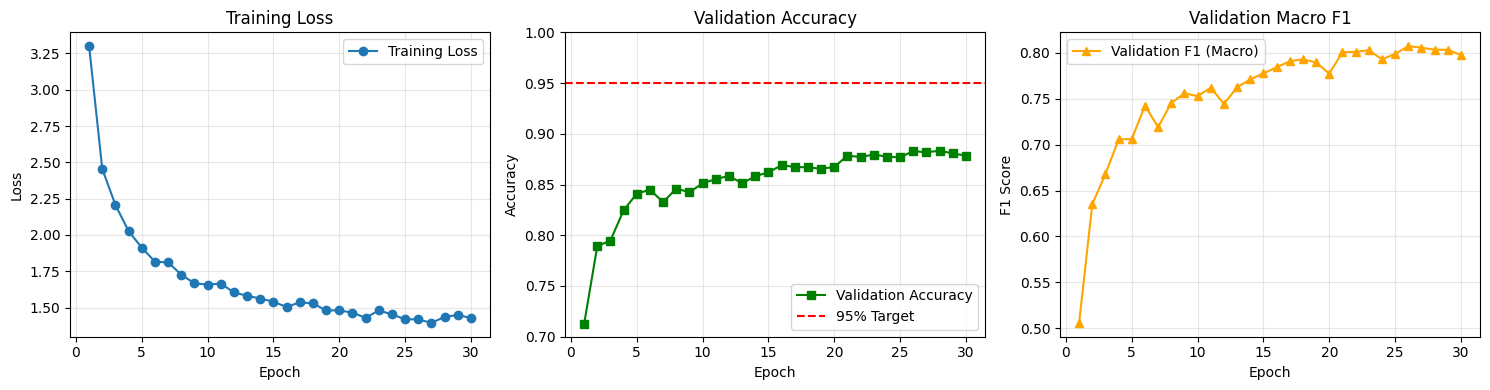

✅ Training curves saved to /kaggle/working/training_curves_efficientnet_stft.png


In [27]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(training_history['epoch'], training_history['train_loss'], marker='o', label='Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Accuracy
axes[1].plot(training_history['epoch'], training_history['val_acc'], marker='s', label='Validation Accuracy', color='green')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% Target')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].set_ylim([0.7, 1.0])
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# F1 Score
axes[2].plot(training_history['epoch'], training_history['val_f1'], marker='^', label='Validation F1 (Macro)', color='orange')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('Validation Macro F1')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.savefig('/kaggle/working/training_curves_efficientnet_stft.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Training curves saved to /kaggle/working/training_curves_efficientnet_stft.png")